In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import copy
import random

random.seed(42)

In [2]:
df = pd.read_csv('data.csv',index_col=0)
# df.drop(['retail_and_recreation_percent_change_from_baseline','grocery_and_pharmacy_percent_change_from_baseline','parks_percent_change_from_baseline','transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline','residential_percent_change_from_baseline'],inplace=True,axis =1)
df1 = copy.deepcopy(df) 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 410 entries, 2020-03-03 to 2021-04-16
Data columns (total 27 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   CASE_COUNT                                          410 non-null    int64  
 1   PROBABLE_CASE_COUNT                                 410 non-null    int64  
 2   CASE_COUNT_7DAY_AVG                                 410 non-null    int64  
 3   ALL_CASE_COUNT_7DAY_AVG                             410 non-null    int64  
 4   DEATH_COUNT                                         410 non-null    int64  
 5   PROBABLE_DEATH_COUNT                                410 non-null    int64  
 6   DEATH_COUNT_7DAY_AVG                                410 non-null    int64  
 7   ALL_DEATH_COUNT_7DAY_AVG                            410 non-null    int64  
 8   TOTAL_TESTS                                         410 non-null    i

In [4]:
df = df.astype(float)
# df.shape
# df = df[:-14]
# df.shape

In [5]:
scaler = StandardScaler()
scaler = scaler.fit(df)
df_train = scaler.transform(df)

In [6]:
trainX = []
trainY = []
n_future = 1   # Number of days we want to predict into the future
n_past = 7     # Number of past days we want to use to predict the future

for i in range(n_past, len(df_train) - n_future +1):
    trainX.append(df_train[i - n_past:i, 0:df_train.shape[1]])
    trainY.append(df_train[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (403, 7, 27).
trainY shape == (403, 1).


In [7]:
ValidationX = trainX[-60:-30]
ValidationY = trainY[-60:-30]
testX = trainX[-30:]
testY = trainY[-30:]
trainX = trainX[:-60]
trainY = trainY[:-60]
trainDates = df1.index[:-60]
testDates = df1.index[-30:]
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

print('ValidationX shape == {}.'.format(ValidationX.shape))
print('ValidationY shape == {}.'.format(ValidationY.shape))

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (343, 7, 27).
trainY shape == (343, 1).
ValidationX shape == (30, 7, 27).
ValidationY shape == (30, 1).
testX shape == (30, 7, 27).
testY shape == (30, 1).


In [8]:
# model = Sequential()
# model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
# model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
# model.add(Dense(1))
# model.compile(loss='mae', optimizer='adam')
# model.add(LSTM(32, activation='relu', return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(trainY.shape[1]))
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
verbose, epochs, batch_size = 0, 70, 16
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainY.shape[1]
print(n_timesteps,n_features,n_outputs)
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(n_outputs))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer='adam')
# model.compile(optimizer='adam', loss='mae')
model.summary()

7 27 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5, 64)             5248      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3, 64)             12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 200)            212000    
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 100)      

In [9]:
history = model.fit(trainX, trainY, epochs=50, batch_size=70, validation_data=(ValidationX,ValidationY), verbose=2, shuffle=False)

Epoch 1/50
5/5 - 2s - loss: 1.0632 - val_loss: 0.5737
Epoch 2/50
5/5 - 0s - loss: 0.8369 - val_loss: 0.5008
Epoch 3/50
5/5 - 0s - loss: 0.5746 - val_loss: 0.3746
Epoch 4/50
5/5 - 0s - loss: 0.4179 - val_loss: 0.2144
Epoch 5/50
5/5 - 0s - loss: 0.3210 - val_loss: 0.1385
Epoch 6/50
5/5 - 0s - loss: 0.1913 - val_loss: 0.1778
Epoch 7/50
5/5 - 0s - loss: 0.2123 - val_loss: 0.3221
Epoch 8/50
5/5 - 0s - loss: 0.1470 - val_loss: 0.1512
Epoch 9/50
5/5 - 0s - loss: 0.1439 - val_loss: 0.1244
Epoch 10/50
5/5 - 0s - loss: 0.1257 - val_loss: 0.1257
Epoch 11/50
5/5 - 0s - loss: 0.1286 - val_loss: 0.1184
Epoch 12/50
5/5 - 0s - loss: 0.1116 - val_loss: 0.1377
Epoch 13/50
5/5 - 0s - loss: 0.1035 - val_loss: 0.1284
Epoch 14/50
5/5 - 0s - loss: 0.0974 - val_loss: 0.0967
Epoch 15/50
5/5 - 0s - loss: 0.0890 - val_loss: 0.1052
Epoch 16/50
5/5 - 0s - loss: 0.0841 - val_loss: 0.1013
Epoch 17/50
5/5 - 0s - loss: 0.0791 - val_loss: 0.0865
Epoch 18/50
5/5 - 0s - loss: 0.0760 - val_loss: 0.0892
Epoch 19/50
5/5 - 0

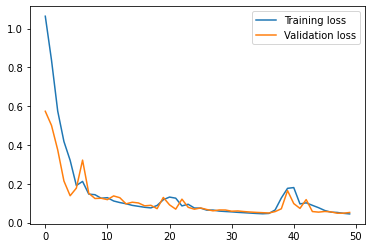

In [10]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [11]:
n_future=14  #Redefining n_future to extend prediction dates beyond original n_future dates...
train_dates = pd.to_datetime(df.index)
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()

forecast = model.predict(testX,verbose=0) #forecast 
print(forecast)
print(forecast.shape)

[[[0.6841476 ]]

 [[0.6233481 ]]

 [[0.2831567 ]]

 [[0.33565894]]

 [[1.0080032 ]]

 [[1.1513951 ]]

 [[1.0721118 ]]

 [[0.5152468 ]]

 [[0.65456283]]

 [[0.33516237]]

 [[0.58192486]]

 [[1.1972291 ]]

 [[1.0618998 ]]

 [[1.154848  ]]

 [[0.90015256]]

 [[0.89074373]]

 [[0.42120284]]

 [[0.45729977]]

 [[1.0392119 ]]

 [[1.0736855 ]]

 [[1.0466813 ]]

 [[0.67280364]]

 [[0.6667981 ]]

 [[0.32049218]]

 [[0.33350438]]

 [[0.7559496 ]]

 [[0.6704341 ]]

 [[0.68026006]]

 [[0.4762714 ]]

 [[0.6464625 ]]]
(30, 1, 1)


In [12]:
forecast_copies = np.repeat(forecast, df_train.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [13]:
# Convert timestamp to date
# forecast_dates = []
# for time_i in forecast_period_dates:
#     forecast_dates.append(time_i.date())

In [14]:
y_pred_future = y_pred_future[:,0]

In [15]:
df_forecast = pd.DataFrame({'Date':testDates, 'Cases':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [16]:
df_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    30 non-null     datetime64[ns]
 1   Cases   30 non-null     float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 488.0 bytes


(30, 2)
<ipython-input-17-a0ae930b25ae>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(df.index)
/home/flamealchemist/projects/NYC/Env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/flamealchemist/projects/NYC/Env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explici

<AxesSubplot:xlabel='Date', ylabel='CASE_COUNT'>

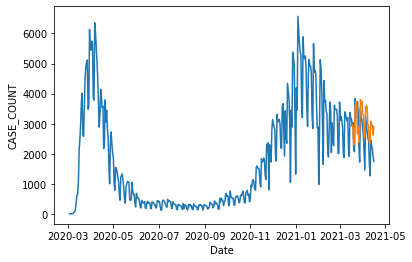

In [17]:
original = df[['CASE_COUNT']]
original['Date']=pd.to_datetime(df.index)
original = original.loc[original['Date'] >= '2020-4-1']
df1['Date'] = pd.to_datetime(df1.index)
print(df_forecast.shape)
sns.lineplot(df1['Date'], df1['CASE_COUNT'])
sns.lineplot(df_forecast['Date'], df_forecast['Cases'])